### Subtitle parsing

In [50]:
from typing import Optional, TextIO


Subt = tuple[float, float, str]

def str_to_secs(time: str) -> float:
	'Amount of seconds for string in xx:xx:xx format'
	hours, mins, secs = time.replace(',','.').split(':')
	return float(hours)*3600 + float(mins)*60 + float(secs)

def process_sub_file(file: TextIO) -> list[Subt]:
	'Takes a .vtt file and returns a list of Subt'
	subs: list[Subt] = []
	start = end = None
	sub: Optional[str] = None
	for line in file:
		if ' --> ' in line:
			start, end = str_to_secs(line.split(' --> ')[0]), str_to_secs(line.split(' --> ')[1][:-1])
		elif start is not None and end is not None:
			if line != '\n':
				if sub is not None:
					sub = sub[:-1] + ' ' + line
				else:
					sub = line
			else:
				if sub is not None and sub[:-1]:
					subs.append((start, end, sub[:-1].replace('- ', '').lower()))
				start = end = sub = None
	if sub is not None and sub[:-1] and (start is not None and end is not None):
		subs.append((start, end, sub[:-1].replace('- ', '').lower()))
	return subs

In [51]:
from pathlib import Path
import pandas as pd


# pd.set_option('display.max_colwidth', None)

input_path = Path('../data/raw')

# Se descarta un video con los subtitulos descoordinados
excluded = ['noticias-en-lengua-de-senas-argentina-resumen-semanal-06122020.vtt']

sub_files = [f for f in input_path.glob('**/*.vtt') if f.name not in excluded]

subtitles: list[dict[str, str | float]] = []
for filename in sub_files:
	with filename.open(encoding='utf-8') as subs_file:
		subtitles += list(map(lambda idx_subt: {
			'id': f"{filename.name[:-4]}_{idx_subt[0]}",
			'label': idx_subt[1][2],
			'video': filename.name[:-4],
			'playlist': filename.parent.name,
			'start': idx_subt[1][0],
			'end': idx_subt[1][1],
		}, enumerate(process_sub_file(subs_file))))

labels = pd.DataFrame(subtitles)

### Adding extra fields and cleaning

In [52]:
labels['duration'] = labels['end'] - labels['start']

In [53]:
import re


labels['label'] = labels['label'].map(lambda x: re.sub(r'<.*?>', '', x))
labels.head()

,id,label,video,playlist,start,end,duration
0,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_0,"para dejar en el camino tanto inglés, para que el país sea un puño apretado",noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,3.90,10.448,6.548
1,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_1,gritando por argentina. argentina 2...,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,10.50,14.640,4.140
2,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_2,lucía: mientras trabajábamos para brindarte toda la información,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,14.72,17.870,3.150
3,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_3,"en nuestro primer programa,",noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,18.09,19.510,1.420
4,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_4,"nos impactó la noticia de la muerte de diego maradona,",noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,19.57,24.330,4.760


#### Removing text between brackets

In [54]:
labels[labels['label'].str.contains(r'\[')]['label']

9        [música]
345      [música]
346      [música]
347      [música]
608      [música]
           ...   
14864    [música]
14865    [música]
14959    [música]
14960    [música]
14961    [música]
Name: label, Length: 211, dtype: object

In [55]:
# Remove text between brackets from labels and delete the ones left empty
labels['label'] = labels['label'].map(lambda x: re.sub(r'\[.*?\]', '', x))
labels = labels[labels['label'].map(lambda x: len(x) > 0)]

labels = labels[labels['label'] != '[♪ música ♪']
labels = labels[labels['label'] != '[música']

labels.reset_index(inplace=True, drop=True)

#### Removing leading speakers

In [56]:
# Remove leading speakers labels that contain only one word followed by a colon:
labels['label'] = labels['label'].map(lambda x: ''.join(x.split(':')[1:]) if x.split(':')[0] in ['lautaro', 'lucía', 'mariana', 'ambos', 'ambas', 'entrevistador'] else x)
labels[labels['label'].str.contains(r'^\w+:')]

,id,label,video,playlist,start,end,duration
1637,noticias-en-lengua-de-senas-argentina-resumen-semanal-03012021_217,"t: sí, si hay personas sordas o alguien quiere hacer alguna donación,",noticias-en-lengua-de-senas-argentina-resumen-semanal-03012021,resumen_semanal,1216.00,1222.22,6.22
1977,noticias-en-lengua-de-senas-argentina-resumen-semanal-10012021_211,federalización: podrás tramitarlo desde cualquier parte del país,noticias-en-lengua-de-senas-argentina-resumen-semanal-10012021,resumen_semanal,1083.72,1091.03,7.31
2083,noticias-en-lengua-de-senas-argentina-resumen-semanal-27122020_66,síntomas: la acidez puede ser causada,noticias-en-lengua-de-senas-argentina-resumen-semanal-27122020,resumen_semanal,336.52,340.12,3.60
3342,noticias-en-lengua-de-senas-argentina-resumen-semanal-17012021_300,"13:35, 13:40.",noticias-en-lengua-de-senas-argentina-resumen-semanal-17012021,resumen_semanal,1732.69,1737.15,4.46
3532,noticias-en-lengua-de-senas-argentina-resumen-semanal-7022021_47,https://turismo.buenosaires.gob.ar/es/ requisitosturistas,noticias-en-lengua-de-senas-argentina-resumen-semanal-7022021,resumen_semanal,299.45,314.72,15.27
6220,lsa-noticias-en-lengua-de-senas-argentina-resumen-semanal-21112021_102,"naturales: fuego. aries, leo y sagitario tierra. tauro, virgo y capricornio.",lsa-noticias-en-lengua-de-senas-argentina-resumen-semanal-21112021,resumen_semanal,1484.18,1498.57,14.39
7402,noticias-en-lengua-de-senas-argentina-resumen-semanal-14022021_347,"https://portal-coronavirus.gba.gob.ar/ y seleccionar la opción ""148 accesible"".",noticias-en-lengua-de-senas-argentina-resumen-semanal-14022021,resumen_semanal,1824.81,1828.72,3.91
7515,lsa-noticias-en-lengua-de-senas-argentina-resumen-semanal-19092021_89,ualá: la empresa que llevó las finanzas personales al celular se convirtió,lsa-noticias-en-lengua-de-senas-argentina-resumen-semanal-19092021,resumen_semanal,1274.18,1282.00,7.82
7673,lsa-noticias-en-lengua-de-senas-argentina-resumen-semanal-17102021_111,automedicación: la facilidad de acceso que tienen los argentinos a sustancias.,lsa-noticias-en-lengua-de-senas-argentina-resumen-semanal-17102021,resumen_semanal,898.78,907.87,9.09
7676,lsa-noticias-en-lengua-de-senas-argentina-resumen-semanal-17102021_114,publicidad: construye la necesidad y el factor estímulo para el consumo,lsa-noticias-en-lengua-de-senas-argentina-resumen-semanal-17102021,resumen_semanal,918.00,925.03,7.03


### Grouping subtitles belonging to the same sentence

In [57]:
labels_grouped = labels.copy()
labels_grouped['splits'] = None
duration_diffs = []

exceptions = (
    "las recomendaciones generales para dormir de la fundación del sueño en eeuu son:", 
    "chevrolet cruze", 
    "por evadir el peaje, equivalente a $ 5.850", 
    "gracias por verme. pueden seguirnos en facebook e instagram, departamento juvenil de la cas. (djcas)", 
    "por suerte, hay igualdad. gracias, un abrazo", 
    "ambas: saludos", 
    "gracias a vos. chau. chau",
    "este es el supermercado “libertad”, primero vean el nombre…", 
    "para más información podés visitar la web www.previaje.gob.ar",
    "veamos…", 
    "para mayor información pueden ingresar a https://www.buenosaires.gob.ar/coronavirus", 
    "comencemos",
    '"om" ',
)
is_eos = lambda subt: subt.endswith('.') or subt.endswith('!') or subt.endswith('?') or subt.endswith('?"') or subt.endswith(exceptions)

i = 0
while i < len(labels_grouped) - 1:
    combined_label = labels_grouped.at[i, 'label']
    combined_duration = labels_grouped.at[i, 'duration']
    splits = [(labels_grouped.at[i, 'label'], labels_grouped.at[i, 'start'], labels_grouped.at[i, 'end'])]
    j = i+1
    while labels_grouped.at[i, 'label'] != "" and not is_eos(combined_label) and labels_grouped.at[i, 'video'] == labels_grouped.at[j, 'video'] and j < len(labels) - 1:
        combined_label += ' ' + labels_grouped.at[j, 'label']
        splits.append((labels_grouped.at[j, 'label'], labels_grouped.at[j, 'start'], labels_grouped.at[j, 'end']))
        labels_grouped.at[j, 'label'] = ''
        combined_duration += labels_grouped.at[j+1, 'duration']
        if labels_grouped.at[j-1,'end'] != labels_grouped.at[j,'start']:
            duration_diffs.append([j-1, j, labels_grouped.at[j,'start'] - labels_grouped.at[j-1,'end']])
        j += 1

    labels_grouped.at[i, 'label'] = combined_label
    labels_grouped.at[i, 'duration'] = combined_duration
    labels_grouped.at[i, 'end'] = labels_grouped.at[j-1, 'end']
    labels_grouped.at[i, 'splits'] = None if len(splits) == 0 else splits
    i += 1

labels_grouped = labels_grouped[labels_grouped['label'] != '']
labels_grouped.reset_index(inplace=True, drop=True)

In [58]:
labels_grouped.head()

,id,label,video,playlist,start,end,duration,splits
0,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_0,"para dejar en el camino tanto inglés, para que el país sea un puño apretado gritando por argentina. argentina 2...",noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,3.90,14.64,9.698,"[(para dejar en el camino tanto inglés, para que el país sea un puño apretado, 3.9, 10.448), (gritando por argentina. argentina 2..., 10.5, 14.64)]"
1,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_2,"mientras trabajábamos para brindarte toda la información en nuestro primer programa, nos impactó la noticia de la muerte de diego maradona, el futbolista conocido mundialmente quien llevó a la argentina a ser campeón en el mundial 86, en medio de un mundo convulsionado.",noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,14.72,37.12,26.420,"[( mientras trabajábamos para brindarte toda la información, 14.72, 17.87), (en nuestro primer programa,, 18.09, 19.51), (nos impactó la noticia de la muerte de diego maradona,, 19.57, 24.33), (el futbolista conocido mundialmente, 24.75, 27.27), (quien llevó a la argentina a ser campeón en el mundial 86,, 27.33, 33.84), (en medio de un mundo convulsionado., 34.0, 37.12)]"
2,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_8,será recordado por siempre. este programa es un homenaje a su persona.,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,37.18,43.54,6.360,"[(será recordado por siempre. este programa es un homenaje a su persona., 37.18, 43.54)]"
3,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_10,"buenas noches. bienvenidos a cn sordos argentina, el primer noticiero de argentina conducido por personas sordas.",noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,76.81,82.66,4.730,"[( buenas noches. bienvenidos a cn sordos argentina,, 76.81, 79.63), (el primer noticiero de argentina conducido por personas sordas., 79.69, 82.66)]"
4,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_12,mi nombre es lucía.,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,82.84,84.75,1.910,"[(mi nombre es lucía., 82.84, 84.75)]"


In [59]:
print(f"Duration before grouping: {labels['duration'].sum()/60/60}")
print(f"Duration after grouping: {labels_grouped['duration'].sum()/60/60}")
print(f"{(labels_grouped['duration'].sum() - labels['duration'].sum())/60} minutes of video were added from in between joint clips time")

Duration before grouping: 21.775591944444447
Duration after grouping: 22.006578611111113
13.859199999999934 minutes of video were added from in between joint clips time


In [60]:
labels_for_analyisis = pd.concat([
    labels["duration"], 
    labels_grouped["duration"], 
    labels["label"].map(lambda x: len(x.split(" "))),
    labels_grouped["label"].map(lambda x: len(x.split(" ")))
], axis=1)
labels_for_analyisis.columns = ["duration", "duration_grouped", "wc", "wc_grouped"]
labels_for_analyisis.describe()

,duration,duration_grouped,wc,wc_grouped
count,14874.000000,8459.000000,14874.000000,8459.000000
mean,5.270414,9.365609,9.129891,16.053671
std,2.733272,7.147170,3.284029,11.168255
min,0.450000,0.580000,1.000000,1.000000
25%,3.330000,4.270000,7.000000,8.000000
50%,4.670000,7.370000,9.000000,13.000000
75%,6.540000,12.340000,12.000000,21.000000
max,25.580000,83.230000,24.000000,156.000000


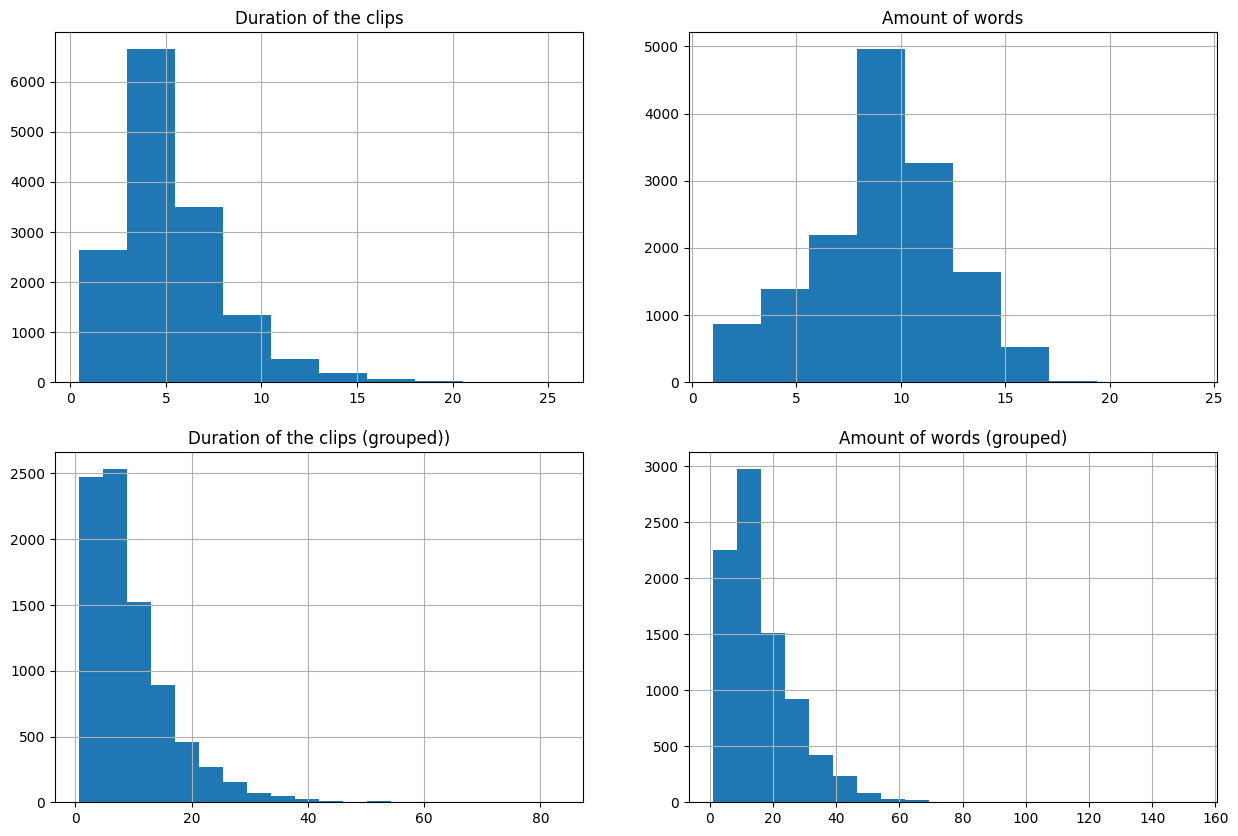

In [61]:
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = (15, 10)

fig, ax = plt.subplots(2, 2)
labels['duration'].hist(ax=ax[0,0])
labels['label'].map(lambda x: len(x.split())).hist(ax=ax[0,1])
ax[0,0].set_title('Duration of the clips')
ax[0,1].set_title('Amount of words')

labels_grouped['duration'].hist(ax=ax[1,0], bins=20)
labels_grouped['label'].map(lambda x: len(x.split())).hist(ax=ax[1,1], bins=20)
ax[1,0].set_title('Duration of the clips (grouped))')
ax[1,1].set_title('Amount of words (grouped)')
plt.show()

#### Analysis of diference of time between joint clips

In [62]:
duration_diffs_s = pd.DataFrame(duration_diffs, columns=['prev', 'next', 'duration_diff'])
duration_diffs_s.describe()

,prev,next,duration_diff
count,6063.000000,6063.000000,6063.000000
mean,7455.711034,7456.711034,0.082482
std,4282.004062,4282.004062,0.210829
min,0.000000,1.000000,-0.008000
25%,3842.500000,3843.500000,0.060000
50%,7459.000000,7460.000000,0.060000
75%,11131.500000,11132.500000,0.060000
max,14871.000000,14872.000000,7.520000


In [63]:
outliers = duration_diffs_s[duration_diffs_s['duration_diff'] > 2].copy().sort_values(by=['duration_diff'], ascending=False)
outliers.reset_index(inplace=True, drop=True)
outliers["label_1"] = outliers.apply(lambda row: labels.at[row['prev'], 'label'], axis=1)
outliers["label_2"] = outliers.apply(lambda row: labels.at[row['next'], 'label'], axis=1)
outliers["video"] = outliers.apply(lambda row: labels.at[row['next'], 'video'], axis=1)
outliers["start"] = outliers.apply(lambda row: labels.at[row['next'], 'start'], axis=1)
outliers

,prev,next,duration_diff,label_1,label_2,video,start
0,202,203,7.520,"los votantes eligen a los representantes de su estado en el colegio electoral,",que es el órgano encargado finalmente,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,858.18
1,272,273,6.820,"mantuvo reuniones las profesoras lorena koch y miriam inozenzi,",con quienes analizaron el proyecto que pide al poder ejecutivo provincial,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,1206.48
2,2594,2595,6.029,son pocos los que saben que esto existe,"se llama ela, considerada por la organización mundial de la salud",noticias-en-lengua-de-senas-argentina-resumen-semanal-09052021,405.69
3,193,194,4.210,"además, no parpadear con tanta frecuencia,",sino hacerlo suavemente para lavar los ojos,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,811.39
4,1780,1781,3.330,"y vos podes ser parte. para que este proyecto siga creciendo,","te pedimos que te suscribas,",noticias-en-lengua-de-senas-argentina-resumen-semanal-10012021,84.54
5,5024,5025,3.120,saludos,"""deafbeerba, un emprendimiento cervecero"".",lsa-noticias-en-lengua-de-senas-argentina-resumen-semanal-23052021,1075.30
6,6322,6323,3.060,y precisa dos situaciones específicas para el goce de la licencia laboral:,"primero, los días en que no concurran a clases presenciales en sus respectivas escuelas.",noticias-en-lengua-de-senas-argentina-resumen-semanal-21022021,614.10
7,214,215,3.000,"sin embargo, no alcanzó, ya que logró 227 votos electorales,",frente a los 304 de trump.,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,915.78
8,278,279,2.880,"y el acceso a la información puede resultarles dificultoso o nulo,","por eso, es necesario generar herramientas",noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,1233.18
9,139,140,2.510,cas.accesiblelsa@gmail.com,para informar la situación. con la siguiente información:,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,601.57


### Adding extra delta before and after adding new subtitles

In [64]:
import numpy as np


i = 0
labels_w_delta = labels_grouped.copy()

labels_w_delta['prev_delta'] = 0
labels_w_delta['post_delta'] = 0

while i < len(labels_w_delta) - 2:
    if labels_w_delta.at[i, 'video'] == labels_w_delta.at[i+1, 'video']:
        labels_w_delta.at[i, 'post_delta'] = max(0, labels_w_delta.at[i+1, 'start'] - labels_w_delta.at[i, 'end'])
        labels_w_delta.at[i+1, 'prev_delta'] = max(0, labels_w_delta.at[i, 'post_delta'])
    else:
        labels_w_delta.at[i, 'post_delta'] = np.nan
        labels_w_delta.at[i+1, 'prev_delta'] = np.nan
    i += 1
labels_w_delta.at[0, 'prev_delta'] = np.nan
labels_w_delta.at[len(labels_w_delta) - 1, 'post_delta'] = np.nan

In [65]:
labels_w_delta.head()

,id,label,video,playlist,start,end,duration,splits,prev_delta,post_delta
0,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_0,"para dejar en el camino tanto inglés, para que el país sea un puño apretado gritando por argentina. argentina 2...",noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,3.90,14.64,9.698,"[(para dejar en el camino tanto inglés, para que el país sea un puño apretado, 3.9, 10.448), (gritando por argentina. argentina 2..., 10.5, 14.64)]",NaN,0.08
1,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_2,"mientras trabajábamos para brindarte toda la información en nuestro primer programa, nos impactó la noticia de la muerte de diego maradona, el futbolista conocido mundialmente quien llevó a la argentina a ser campeón en el mundial 86, en medio de un mundo convulsionado.",noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,14.72,37.12,26.420,"[( mientras trabajábamos para brindarte toda la información, 14.72, 17.87), (en nuestro primer programa,, 18.09, 19.51), (nos impactó la noticia de la muerte de diego maradona,, 19.57, 24.33), (el futbolista conocido mundialmente, 24.75, 27.27), (quien llevó a la argentina a ser campeón en el mundial 86,, 27.33, 33.84), (en medio de un mundo convulsionado., 34.0, 37.12)]",0.08,0.06
2,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_8,será recordado por siempre. este programa es un homenaje a su persona.,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,37.18,43.54,6.360,"[(será recordado por siempre. este programa es un homenaje a su persona., 37.18, 43.54)]",0.06,33.27
3,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_10,"buenas noches. bienvenidos a cn sordos argentina, el primer noticiero de argentina conducido por personas sordas.",noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,76.81,82.66,4.730,"[( buenas noches. bienvenidos a cn sordos argentina,, 76.81, 79.63), (el primer noticiero de argentina conducido por personas sordas., 79.69, 82.66)]",33.27,0.18
4,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020_12,mi nombre es lucía.,noticias-en-lengua-de-senas-argentina-resumen-semanal-29112020,resumen_semanal,82.84,84.75,1.910,"[(mi nombre es lucía., 82.84, 84.75)]",0.18,32.00


In [66]:
labels_w_delta[['prev_delta', 'post_delta']].describe(percentiles=[.25, .5, .75, .85, .9])

,prev_delta,post_delta
count,8395.000000,8395.000000
mean,1.714692,1.714692
std,16.406378,16.406378
min,0.000000,0.000000
25%,0.060000,0.060000
50%,0.060000,0.060000
75%,0.060000,0.060000
85%,0.400000,0.400000
90%,1.760000,1.760000
max,661.730000,661.730000


In [67]:
labels_w_delta.to_csv('../data/labels.csv', index=False)